In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="7"

Mon Aug 14 21:36:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   39C    P0    65W / 300W |   3584MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Hyperparams

In [3]:
n_mels = 80
n_outputs = 61
n_frames = 400

### Model

In [4]:
from model.model_conditional_dvae import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(n_mels, 512, n_outputs, 16, kernel_size=3, n_blocks=5, n_layers=6)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
print('done')

done


### Load

In [6]:
save_dir = '/data/scpark/save/lips/train08.14-2/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if True:
    step, model, _, optimizer = load(save_dir, 17000, model, None, optimizer)

total 27554828
-rw-rw-r-- 1 scpark scpark          0  8월 14 21:36 events.out.tfevents.1692016596.GPUSVR11
-rw-rw-r-- 1 scpark scpark       1782  8월 14 21:23 events.out.tfevents.1691991917.GPUSVR11
-rw-rw-r-- 1 scpark scpark 1567557799  8월 14 21:23 save_17000
-rw-rw-r-- 1 scpark scpark 1567557799  8월 14 21:00 save_16000
-rw-rw-r-- 1 scpark scpark 1567557799  8월 14 20:37 save_15000
-rw-rw-r-- 1 scpark scpark 1567557799  8월 14 20:13 save_14000
-rw-rw-r-- 1 scpark scpark 1567557799  8월 14 19:50 save_13000
-rw-rw-r-- 1 scpark scpark 1567557799  8월 14 19:27 save_12000
-rw-rw-r-- 1 scpark scpark 1567557799  8월 14 19:04 save_11000
-rw-rw-r-- 1 scpark scpark 1567557799  8월 14 18:41 save_10000
-rw-rw-r-- 1 scpark scpark 1567556161  8월 14 18:17 save_9000
-rw-rw-r-- 1 scpark scpark 1567556161  8월 14 17:53 save_8000
-rw-rw-r-- 1 scpark scpark 1567556161  8월 14 17:30 save_7000
-rw-rw-r-- 1 scpark scpark 1567556161  8월 14 17:07 save_6000
-rw-rw-r-- 1 scpark scpark 1567556161  8월 14 16:43 save_5000
-r

### Dataset

In [7]:
import os
from data.arkit_dataset import LipsDataset, CombinedDataset, CombinedCollate

root_dir = '/data/speech/digital_human/preprocessed/'

def get_files(dir):
    data = []
    files = sorted([os.path.join(dir, file) for file in os.listdir(dir)])
    for file in files:
        if file.endswith('.npy') and 'ARKit' in file:
            data.append(file)
        if os.path.isdir(file):
            data.extend(get_files(os.path.join(dir, file)))
    return data

files = get_files(root_dir)
print(len(files))

train_datasets = []
test_datasets = []

def get_sid(file):
    names = ['No Speaker', 'jeewonPark', 'jinwooOh', 'kyuchulLee', 'kyuseokKim', 'nohsikPark', 'soochulPark', 'yehunHwang']
    for sid, name in enumerate(names):
        if name in file:
            return sid
    return 0

for file in files:
    sid = get_sid(file)
    print(sid, file)
    dataset = LipsDataset(file, n_mels, n_frames, sid=sid, mel=False)
    if '_10_' in file:
        test_datasets.append(dataset)
    else:
        train_datasets.append(dataset)
print(len(train_datasets), len(test_datasets))

76
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_10_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_11_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_12_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_1_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_2_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_3_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_4_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_5_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_8_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_9_iPhone_raw.npy
2 /data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_10_iPhone_raw.npy
2 /data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_1_iPhone_raw.npy
2

In [8]:
train_loader = torch.utils.data.DataLoader(CombinedDataset(train_datasets), 
                                           num_workers=16, shuffle=True, batch_size=32, collate_fn=CombinedCollate())
test_loader = torch.utils.data.DataLoader(CombinedDataset(test_datasets), 
                                          num_workers=10, shuffle=True, batch_size=10, collate_fn=CombinedCollate())
print('done')

done


In [9]:
from functools import partial
from data.audio import mel_spectrogram
get_mel = partial(mel_spectrogram, n_fft=2048, num_mels=80, sampling_rate=24000, hop_size=800, win_size=2048, fmin=0, fmax=None, center=False, return_spec=False)
    
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

test : 0 0.004117246717214584
test : 1 0.004148034378886223
test : 2 0.0026265732012689114
test : 3 0.003651539096608758
test : 4 0.0033383755944669247
test : 5 0.0039725713431835175
test : 6 0.0036582606844604015
test : 7 0.0036680144257843494
test : 8 0.003905466990545392
test : 9 0.00397443724796176
test_loss : 0.0037060522008687258


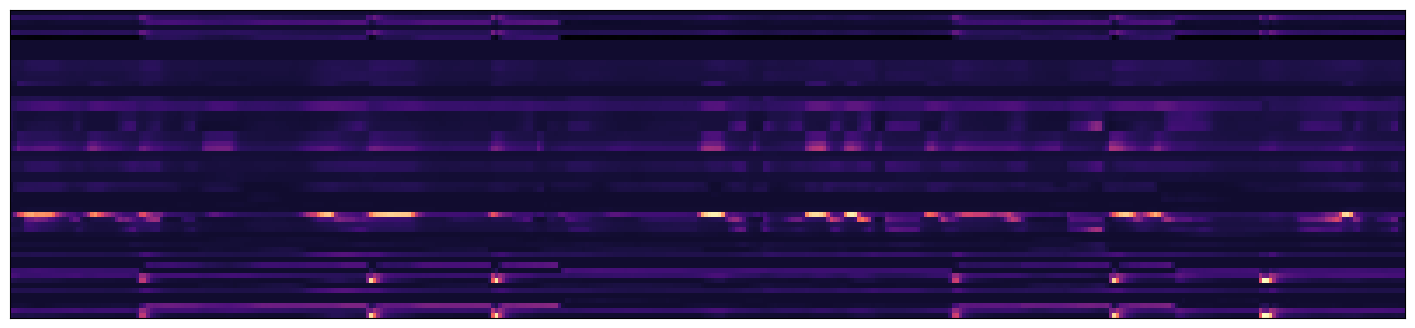

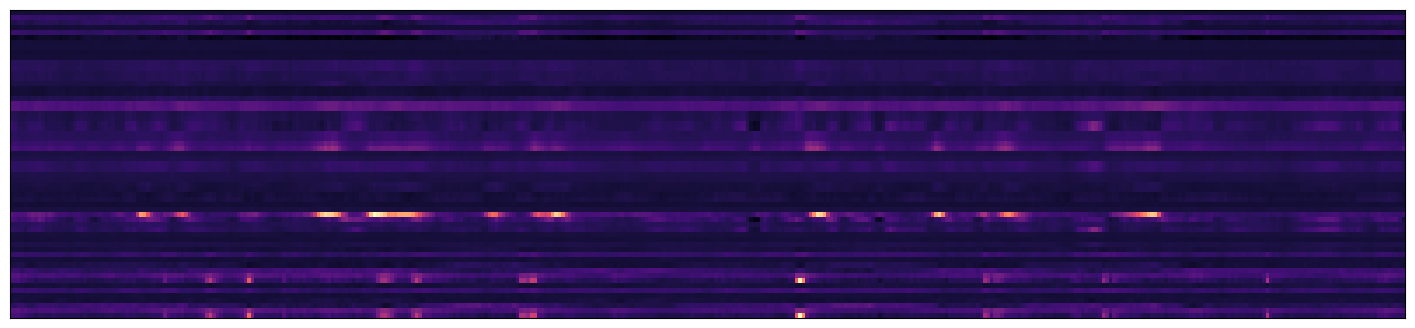

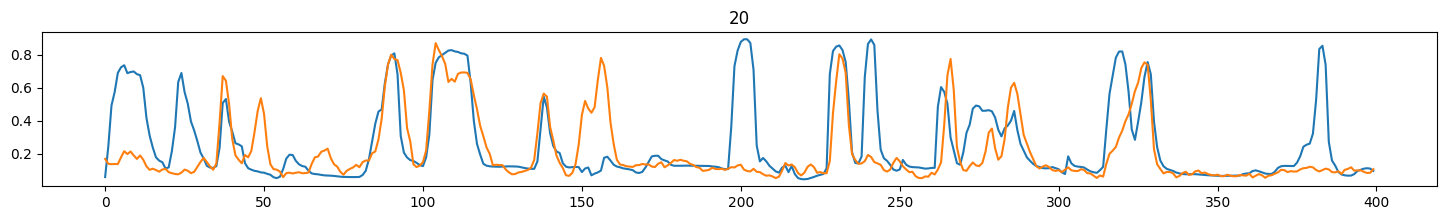

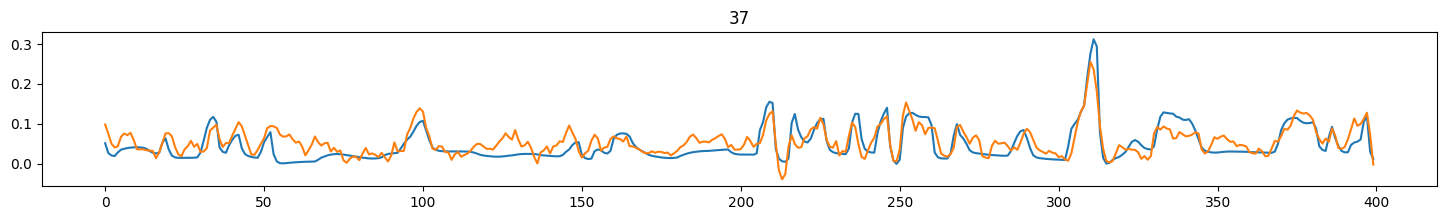

17001
recon_loss 0.0014409436844289303
kl_loss 4.805759454029612e-05
17001 0.0014572842046618462
17002
recon_loss 0.001240559620782733
kl_loss 1.7368811313644983e-05
17002 0.0012464657193049788
17003
recon_loss 0.0011594254756346345
kl_loss 4.4770862587029114e-05
17003 0.001174650271423161
17004
recon_loss 0.0013867992674931884
kl_loss 3.9145521441241726e-05
17004 0.0014001118252053857
17005
recon_loss 0.001385471667163074
kl_loss 2.1580732209258713e-05
17005 0.0013928113039582968
17006
recon_loss 0.0012484563048928976
kl_loss 2.8626442144741304e-05
17006 0.0012581927003338933
17007
recon_loss 0.0013015182921662927
kl_loss 2.097516698995605e-05
17007 0.0013086528051644564
17008
recon_loss 0.0010025090305134654
kl_loss 2.5905517759383656e-05
17008 0.0010113210882991552
17009
recon_loss 0.0012546555371955037
kl_loss 1.8911983715952374e-05
17009 0.0012610889971256256
17010
recon_loss 0.001120024360716343
kl_loss 1.0667386050045025e-05
17010 0.001123653375543654
17011
recon_loss 0.00119800

17086
recon_loss 0.001011644140817225
kl_loss 1.2383693501760717e-05
17086 0.0010158759541809559
17087
recon_loss 0.001009395346045494
kl_loss 9.609877452021465e-06
17087 0.001012679422274232
17088
recon_loss 0.001041768817231059
kl_loss 1.0559468137216754e-05
17088 0.0010453775757923722
17089
recon_loss 0.0010950335999950767
kl_loss 1.25712849694537e-05
17089 0.0010993302566930652
17090
recon_loss 0.0011477010557428002
kl_loss 7.481061402359046e-06
17090 0.0011502581182867289
17091
recon_loss 0.0012713721953332424
kl_loss 1.4191044101607986e-05
17091 0.0012762229889631271
17092
recon_loss 0.0010896968888118863
kl_loss 8.74949819262838e-06
17092 0.001092687831260264
17093
recon_loss 0.0011899011442437768
kl_loss 7.29791554476833e-06
17093 0.0011923960410058498
17094
recon_loss 0.0012540342286229134
kl_loss 1.573871668369975e-05
17094 0.0012594149447977543
17095
recon_loss 0.0012361485278233886
kl_loss 1.1693476153595839e-05
17095 0.001240146579220891
17096
recon_loss 0.0010790940141305

17171
recon_loss 0.0010481098433956504
kl_loss 3.4396616683807224e-05
17171 0.0010599222732707858
17172
recon_loss 0.0010685935849323869
kl_loss 6.66762498440221e-05
17172 0.0010914928279817104
17173
recon_loss 0.001183018321171403
kl_loss 6.943516928004101e-05
17173 0.0012068664655089378
17174
recon_loss 0.0011506375158205628
kl_loss 6.488373765023425e-05
17174 0.0011729238322004676
17175
recon_loss 0.0012285924749448895
kl_loss 5.1315750170033425e-05
17175 0.001246219384483993
17176
recon_loss 0.0010362208122387528
kl_loss 4.6997352910693735e-05
17176 0.0010523652890697122
17177
recon_loss 0.0011361042270436883
kl_loss 3.3026604796759784e-05
17177 0.0011474501807242632
17178
recon_loss 0.0009966150391846895
kl_loss 0.00012648124538827688
17178 0.0010400689207017422
17179
recon_loss 0.0010662158019840717
kl_loss 5.86686801398173e-05
17179 0.0010863732313737273
17180
recon_loss 0.00115958193782717
kl_loss 5.893615889362991e-05
17180 0.0011798323830589652
17181
recon_loss 0.001061288989

17255 0.0013874578289687634
17256
recon_loss 0.0010986847337335348
kl_loss 6.246707926038653e-06
17256 0.0011008406290784478
17257
recon_loss 0.001039066701196134
kl_loss 6.868926448078128e-06
17257 0.0010414374992251396
17258
recon_loss 0.0011510492768138647
kl_loss 1.5273908502422273e-05
17258 0.0011563212610781193
17259
recon_loss 0.0012672696029767394
kl_loss 5.664935542881722e-06
17259 0.0012692250311374664
17260
recon_loss 0.0013363221660256386
kl_loss 8.9405975813861e-06
17260 0.0013394084526225924
17261
recon_loss 0.0014162095030769706
kl_loss 9.847679393715225e-06
17261 0.0014196090633049607
17262
recon_loss 0.0011237411526963115
kl_loss 4.880037067778176e-06
17262 0.0011254259152337909
17263
recon_loss 0.0011032214388251305
kl_loss 5.864355443918612e-06
17263 0.0011052461341023445
17264
recon_loss 0.0011939902324229479
kl_loss 6.161998953757575e-06
17264 0.001196117838844657
17265
recon_loss 0.0012005834141746163
kl_loss 9.486694580118638e-06
17265 0.0012038592249155045
17266

In [ ]:
from IPython import display
import librosa.display
import matplotlib.pyplot as plt

isnan = False
while True:
    if isnan:
        break
    for batch in train_loader:
        inputs = get_mel(torch.Tensor(batch['wav'])).to(device)
        targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
        sid = torch.Tensor(batch['sid']).int().to(device)
        
        model.train()
        model.zero_grad()
        outputs = model(inputs, targets, sid)
        
        print(step)
        loss = 0
        for key in outputs.keys():
            if 'loss' in key:
                if 'kl' in key:
                    beta = linear(0, 1, step, 0, 50000)
                    loss = loss + outputs[key] * beta
                else:    
                    loss += outputs[key]
                print(key, outputs[key].item())
        if torch.isnan(loss):
            isnan = True
            break
        loss.backward()
        optimizer.step()
        print(step, loss.item())
        
        if step % 1000 == 0:
            writer.add_scalar('train_loss', loss.item(), step)
        
        if step % 1000 == 0:
            display.clear_output()
            
            losses = []
            for i, batch in enumerate(test_loader):
                if i >= 10:
                    break
                    
                inputs = get_mel(torch.Tensor(batch['wav'])).to(device)
                targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
                sid = torch.Tensor(batch['sid']).int().to(device)

                model.eval()
                with torch.no_grad():
                    outputs = model(inputs, targets, sid)
                    
                loss = 0
                for key in outputs.keys():
                    if 'loss' in key:
                        loss += outputs[key]
                print('test :', i, loss.item())
                losses.append(loss)        
            
            test_loss = torch.stack(losses).mean().item()
            print('test_loss :', test_loss)
            writer.add_scalar('test_loss', test_loss, step)
            
            plt.figure(figsize=[18, 4])
            librosa.display.specshow(targets[0].data.cpu().numpy(), cmap='magma')
            plt.show()

            plt.figure(figsize=[18, 4])
            librosa.display.specshow(outputs['y_pred'][0].data.cpu().numpy(), cmap='magma')
            plt.show()
            
            for i in [20, 37]:
                plt.figure(figsize=[18, 2])
                plt.title(str(i))
                plt.plot(targets[0].data.cpu().numpy()[i])
                plt.plot(outputs['y_pred'][0].data.cpu().numpy()[i])
                plt.show()

        if step % 10000 == 0:
            save(save_dir, step, model, None, optimizer)
    
        step += 1

In [ ]:
save(save_dir, step, model, None, optimizer)